In [1]:
from PIL import Image
import numpy as np

file_path = 'E:\SamplePhotos\P1240040.jpg' # defien file path
im = Image.open(file_path) # import pictuate as Pillow Image object
pix = np.array(im) # convert to Numpy aray
h, w, d = orig_shape = tuple(pix.shape) # store original shape of array
pix_flat = np.reshape(pix, (h*w, d)) # flatten image for clustering
print(file_path)

E:\SamplePhotos\P1240040.jpg


In [2]:
## initiate sklearnex
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import KMeans # import K means
import matplotlib.pyplot as plt

no_clusters = 5 # start clustering from 5 clusters
clusterMin = 1 # set cluster min at 1 to enter while loop
while clusterMin > 0.01: # continue to increase number of clusters until the smallest cluster becomes suficently small to just be stripes
    print(no_clusters)
    kmeans = KMeans(n_clusters = no_clusters) # define cluster object
    cluster = kmeans.fit(pix_flat) # find clusters
    labels = cluster.labels_ # save cluster labels as a list
    percent = np.unique(labels, return_counts=True) # get counts # pixels in each cluster
    stripeColour = np.where(percent[1] == min(percent[1])) # return label of least frequent pixel
    clusterMin = min(percent[1]) / (h*w) # find fraction of picture occupied by smallest cluster
    print(clusterMin)
    no_clusters += 1 # increase cluster counter by 1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


5
0.07214841666666667
6
0.07286116666666667
7
0.0067115


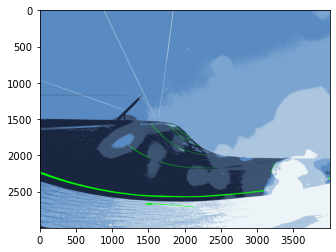

In [3]:
kmeans_image = cluster.cluster_centers_ # save cluster centres to plot image to check clusters
kmeans_image[stripeColour] = np.asarray([0,255,0]) # change the stripe cluster centre to lime green
kmeans_image = cluster.cluster_centers_[cluster.labels_] # assign each pixcel itc cluster colour
kmeans_image = np.reshape(kmeans_image, orig_shape) # reshape array for plotting
plt.imshow(kmeans_image.astype('uint8')) # plot image
plt.show()


In [4]:
vert_ex = 1
labels = np.reshape(labels,(h,w)) # reshape labels array in 2d array (like picture)
stripes = np.where(labels == stripeColour) # get coordinates of all pixels which are a stripe colour
stripes = np.asarray(stripes) # build 2d array of stripe coordinates for clustering
stripes = np.transpose(stripes) # transpose array so as cordinates are pairs
stripes_Vexagerated = np.copy(stripes) # move coordinates into V-Exagerate
stripes_Vexagerated[:,0] = stripes_Vexagerated[:,0] * vert_ex # apply vertical exageration

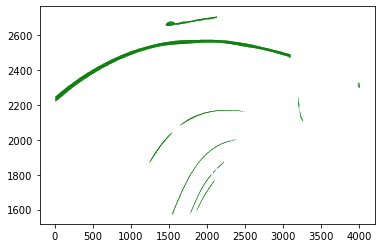

In [5]:
plt.plot(stripes_Vexagerated[:,1], stripes_Vexagerated[:,0], 'o', markersize=0.01, color='green') # create scatter plot of vertical exagerated stripes

In [6]:
stripes_single = np.copy(stripes[np.lexsort((stripes[:,0], stripes[:,1]))]) # sort stripes array by column values and then the row values
start_stop = np.where(np.diff(stripes_single[:,0], axis=0) != 1) # return index of locations where the difference between elements is not 1
start_stop = list(start_stop[0]) # convert start_stop to list
start_stop.insert(0,0) # insert a leading zero to mark start of first stripe
new_cols = np.where(np.diff(stripes_single[:,1], axis=0) == 1) # idetify indecies of start stop the corespond to new columns
new_cols = list(new_cols[0]) # convert new_cols to list so as it can be used to index array
new_cols.insert(0,0) # add leading zero
final_ind = [] # emty list to append stripe indecies on
for i in range(len(new_cols)-1): # iterate over all of the new columns
    col_starts = start_stop.index(new_cols[i]) # get the index of the startiung value
    col_ends = start_stop.index(new_cols[i+1]) # get the index of the finishing value
    if col_ends - col_starts == 1: # chewck if there other other indeces between the start and finish of the column
        centre_index = int((start_stop[col_ends] + start_stop[col_starts]) / 2) # if no intermediate calculate centre as average of the start and end of column
        final_ind.append(centre_index) # append to final ind

    else: # if other indeces are present
        sub_start_stop = start_stop[col_starts:col_ends+1] # create sub start stop as all indeces in given column of image
        sub_start_stop[0] = sub_start_stop[0]+1 # increase index of first value by one as start stop contains the last index of each block of "stripe colour"
        toDrop = [] # create empty list of indeces to drop
        for j in range(1,(len(sub_start_stop)-1)): # iterate over each value in sub start stop
            if (stripes_single[sub_start_stop[j]+1,0] - stripes_single[sub_start_stop[j], 0]) < 6: # check if the block only occurs due to a small gab pf "stripe colour"
                if j != 0 or j != len(sub_start_stop)-1: # if the value isn't the first or last value in the sub_start_stop
                    toDrop.append(j) # append to "toDrop
        val_to_drop = [sub_start_stop[drop] for drop in toDrop] # iterate over toZdrop and get values to be dropped
        [sub_start_stop.remove(val) for val in val_to_drop] # iterate over values to drop and drop from sub start stop
        centre_index = [int(sum(sub_start_stop[m:m+2])/2) for m in range(len(sub_start_stop)-1)] # iterate over remaing sub_start_stop and calculate the centre of each block and save index
        [final_ind.append(index) for index in centre_index] # iterate over index and append to index final
final_ind.sort() # sort final indicies for completeness
stripes_single = np.copy(stripes_single[final_ind,:]) # recreate stripes single using only the indices found.

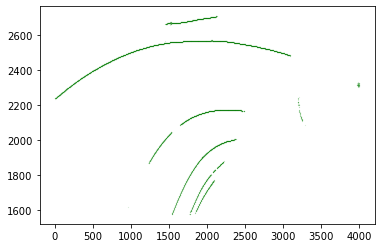

In [7]:
plt.plot(stripes_single[:,1], stripes_single[:,0], 'o', markersize=0.05, color='green') # create scatter plot of vertical exagerated stripes

In [8]:
from sklearn.cluster import DBSCAN # import DB Scan
distance = 100 # set inital eps (distance to jump in clustering) to 25
repeated_cluster = True # set to true to enter while loop
while repeated_cluster:
    print(distance)
    stripe_clusters = DBSCAN(eps=distance, min_samples=10).fit(stripes_Vexagerated) # fit clusters using DB SCAN

    assesment_array = np.empty([h,w]) # make empty array to build an array to asses if each vertical has all unique values
    assesment_array[:] = np.nan
    for i in range(len(stripes_single[:,0])): # iterate over all stripe coridnates
        n = stripes_single[i,0] # assign n the row number of the stripe
        n = int(n/vert_ex)
        m = stripes_single[i,1] # assign m the column number of the stripe
        x = np.where(stripes[:,0] == n)
        y = np.where(stripes[:,1] == m)
        lab_ind = np.intersect1d(x,y)
        if stripe_clusters.labels_[lab_ind] != -1: # dont assing lable to outliers
            assesment_array[n,m] = stripe_clusters.labels_[lab_ind] # assign the label

    repeated_cluster = np.where(np.diff(np.sort(assesment_array, axis=0), axis=0) == 0) # check if columns have alot of the same cluster
    repeated_cluster = len(repeated_cluster[0]) > 1 # if no more than 10 repeated clusters break while loop
    distance -= 5

100
95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5
0


ValueError: eps must be positive.

In [ ]:
colours = [] # empty list to build colour for each cluster in
counter = 0
while counter < len(np.unique(stripe_clusters.labels_)): # build enough colour for each cluster
    colours.append(np.random.choice(range(256), size = 3)) # make random colour
    counter += 1
colours = np.array(colours) # convert colours to array
colours = colours[stripe_clusters.labels_] # assign colours to each test stripe

assesment_image = np.empty(orig_shape) # make empty array to build image of stripe clusters in
for i in range(len(stripes_Vexagerated[:,0])): # iterate over all stripe coridnates
    n = stripes_Vexagerated[i,0] # assign n the row number of the stripe
    n = int(n/vert_ex) # remove vertical exageration
    m = stripes_Vexagerated[i,1] # assign m the column number of the stripe
    assesment_image[n,m] = colours[i,:] # assign the label

plt.imshow(assesment_image.astype('uint8')) # plot image
plt.imsave('stripes.png', assesment_image.astype('uint8'))

In [15]:

cluster_Grads = {} # create empty dictionary to store gradient and average height of each cluster
outlier_ind = []
for lab in np.unique(stripe_clusters.labels_): # iterate over each label
    if lab != -1: # only asses if not already identified as an outlier
        location = np.where(stripe_clusters.labels_ == lab) # return location of stripes with label "lab in stripes array
        x = stripes[location,1][0] # return x value of stripe
        y = stripes[location, 0][0] # return y vlaue of stripe
        m,b = np.polyfit(x,y,1) # find gradient and intercept
        height = sum(x)/len(x) # record average height of cluster
        volume = len(x)
        position = sum(y)/len(y)
        horizontal_density = len(np.unique(x))/len(np.unique(y))
        cluster_Grads[lab] = [m, horizontal_density] # store gradient and height in dictionary
outlier_data = list(cluster_Grads.values()) # get dict values
outlier_data = np.asarray(outlier_data) # convert to array















In [19]:
## determine if most common gradient and density then remove those that are not

gradient = list(outlier_data[:,0])
positive = sum(map(lambda x : x > 0, gradient))

In [11]:
print(outlier_data)

[[ 0.55680094  1.92074592]
 [ 0.81350376  1.25791855]
 [ 0.94186047  1.16666667]
 [ 0.72824191  1.3583815 ]
 [ 0.45315903  2.05263158]
 [ 0.412607    2.3       ]
 [ 0.58289336  1.72159091]
 [ 0.10204082  5.        ]
 [ 0.10042219  9.21348315]
 [-1.31642254  0.78688525]
 [-0.04390244  4.5       ]
 [-1.64288333  0.26984127]
 [ 0.08322347  8.73446328]
 [-0.1940371   1.        ]
 [ 0.06285349 12.53703704]]


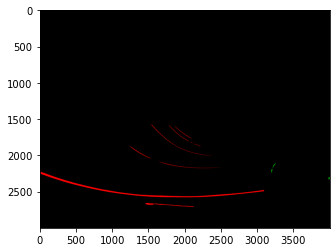

In [17]:
colours = [] # empty list to build colour for each cluster in
counter = 0
while counter < len(np.unique(stripe_clusters.labels_)): # build enough colour for each cluster
    colours.append(np.random.choice(range(256), size = 4)) # make random colour
    counter += 1
colours[0] = np.asarray([255,0,0]) #-1
colours[1] = np.asarray([255,0,0]) #0
colours[2] = np.asarray([255,0,0]) # 1
colours[3] = np.asarray([255,0,0]) # 2
colours[4] = np.asarray([255,0,0]) # 3
colours[5] = np.asarray([255,0,0]) #4
colours[6] = np.asarray([255,0,0]) #5
colours[7] = np.asarray([255,0,0]) #6
colours[8] = np.asarray([255,0,0]) #7
colours[9] = np.asarray([0,255,0]) #9
colours[10] = np.asarray([255,255,0]) #10
colours[11] = np.asarray([0,255,0]) #11
colours[12] = np.asarray([255,0,0]) #12
colours[13] = np.asarray([0,255,0]) #13
colours[14] = np.asarray([255,0,0]) # 14
colours[15] = np.asarray([0,0,0]) #14
colours = np.array(colours) # convert colours to array
colours = colours[stripe_clusters.labels_] # assign colours to each test stripe

assesment_image = np.empty(orig_shape) # make empty array to build image of stripe clusters in
for i in range(len(stripes_Vexagerated[:,0])): # iterate over all stripe coridnates
    n = stripes_Vexagerated[i,0] # assign n the row number of the stripe
    n = int(n/vert_ex) # remove vertical exageration
    m = stripes_Vexagerated[i,1] # assign m the column number of the stripe
    assesment_image[n,m] = colours[i,:] # assign the label

plt.imshow(assesment_image.astype('uint8')) # plot image
plt.imsave('stripes.png', assesment_image.astype('uint8'))

